In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [4]:
prec =  pd.read_csv("Datos/Transformados/activos.csv", index_col=0)
prec.index = pd.to_datetime(prec.index)
precios = prec[['AAPL','CAT','MSFT']]
ret_simple = precios.pct_change().dropna()
ret_log = np.log(precios / precios.shift(1)).dropna()
rend = ret_log
corr_matrix = rend.corr().values
print("Matriz de correlaciones:\n", corr_matrix)
sigma_daily = rend.std().values
sigmas = sigma_daily * np.sqrt(252)
print("Volatilidades anualizadas:", sigmas)
S0 = precios.iloc[-1].values
print("Precios iniciales:", S0)
T = 5         
r = 0.02    
N = 20 
n_sim = 5000

Matriz de correlaciones:
 [[1.         0.40273855 0.72089394]
 [0.40273855 1.         0.4063413 ]
 [0.72089394 0.4063413  1.        ]]
Volatilidades anualizadas: [0.34008671 0.3430685  0.30625337]
Precios iniciales: [137.27000427 216.71000671 271.6000061 ]


In [18]:
sigmas

array([0.34008671, 0.3430685 , 0.30625337])

In [19]:
import numpy as np
def generar_P(M, n, T, corr, rf, vol, seed=42):
    """
    Genera la matriz P_t = np.e**((rf - (vol**2/2))*dt + vol*np.sqrt(dt)*Z)
    usando Z correlacionados con Cholesky.
    Condiciones:
    - Los primeros 5 pasos son iguales para todos los paths.
    - Del paso 6 al 20 son aleatorios correlacionados.
    - rf: tasa libre de riesgo (constante)
    - vol: volatilidad (constante o array de tamaño n_assets)
    """
    dt = T/n
    np.random.seed(seed)
    # --- Descomposición de Cholesky para correlación ---
    L = np.linalg.cholesky(corr)
    n_assets = corr.shape[0]
    # --- Matriz vacía para Z ---
    Z = np.zeros((M, n, n_assets))
    # --- Primeros 5 pasos iguales ---
    rng = np.random.default_rng(seed=seed)
    Z_comun = rng.standard_normal(size=(5, n_assets))
    Z_comun = Z_comun @ L.T
    for p in range(M):
        Z[p, 0:5, :] = Z_comun
    # --- Pasos 6 a 20 distintos ---
    for p in range(M):
        Z_ind = rng.standard_normal(size=(n - 5, n_assets))
        Z_ind = Z_ind @ L.T
        Z[p, 5:, :] = Z_ind
    # Aplicar la fórmula larga exactamente
    P = np.e ** ((rf - (vol**2 / 2)) * dt + (vol * np.sqrt(dt) * Z))
    P = np.concatenate([np.ones((M, 1, n_assets)), P], axis=1)
    return P, Z


In [20]:
T = 5         # años
r = 0.02      # tasa libre de riesgo
N = 20 # pasos diarios (5 años)
M = 50000
seed = 123
print("Volatilidades anualizadas:", sigmas)

Volatilidades anualizadas: [0.34008671 0.3430685  0.30625337]


In [21]:
S0 = precios.iloc[-1].values

In [22]:
P, Z= generar_P(M=10000, n = N, T = T, rf = r, vol = sigmas, corr = corr_matrix)
valores = np.cumprod(P, axis=1)
medias = np.mean(valores,  axis = 1)
root_values = medias ** (1/20)
root_values
sum_values = np.sum(root_values, axis=1)
payoff = np.maximum(np.sum(medias, axis = 1) - 3, 0)
media_payoffs = payoff.mean()
media_payoffs * np.e**(-r * T)

np.float64(0.2586124022111121)

In [23]:
valores

array([[[1.        , 1.        , 1.        ],
        [1.04326763, 0.85903399, 1.08874664],
        [1.21268529, 0.66830593, 1.0084391 ],
        ...,
        [1.31005592, 1.02445975, 1.31028023],
        [1.1979703 , 0.88838469, 1.18588313],
        [1.53016592, 0.85152279, 1.51135741]],

       [[1.        , 1.        , 1.        ],
        [1.04326763, 0.85903399, 1.08874664],
        [1.21268529, 0.66830593, 1.0084391 ],
        ...,
        [0.4864918 , 0.3023977 , 0.57589983],
        [0.41314225, 0.26509889, 0.5884372 ],
        [0.38519677, 0.28760118, 0.51714556]],

       [[1.        , 1.        , 1.        ],
        [1.04326763, 0.85903399, 1.08874664],
        [1.21268529, 0.66830593, 1.0084391 ],
        ...,
        [1.41725085, 0.6281481 , 0.93977764],
        [1.22265701, 0.55097466, 0.79413758],
        [1.18249717, 0.63881685, 0.80598483]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.04326763, 0.85903399, 1.08874664],
        [1.21268529, 0

C:\Users\lande\AppData\Local\Temp\ipykernel_28928\3185568031.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


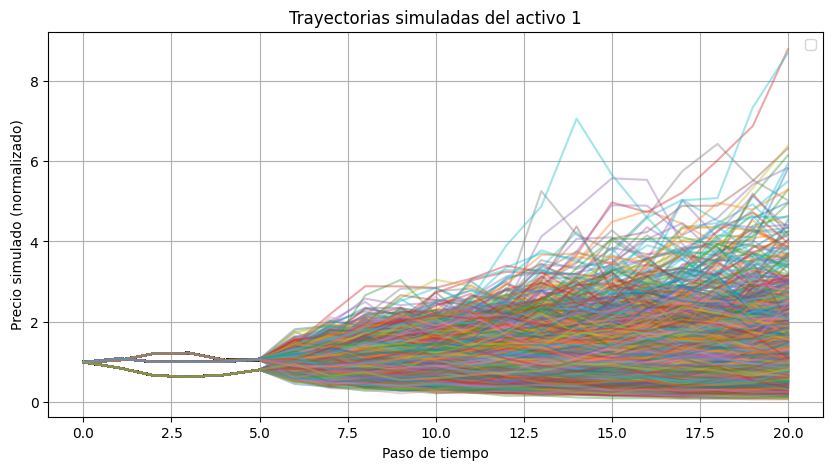

In [24]:
plt.figure(figsize=(10, 5))
for i in range(1000):  # plotea 20 trayectorias aleatorias del activo 1
    plt.plot(valores[i, :, :], alpha=0.4)
# plt.axhline(y=S0.sum(), color='red', linestyle='--', label = f'E: {S0.sum():.2f}')
# Comentado porque el S0 tiene un valor de 600, y si no las lineas de los activos no se ven. 
plt.title("Trayectorias simuladas del activo 1")
plt.xlabel("Paso de tiempo")
plt.ylabel("Precio simulado (normalizado)")
plt.legend()
plt.grid(True)
plt.show()

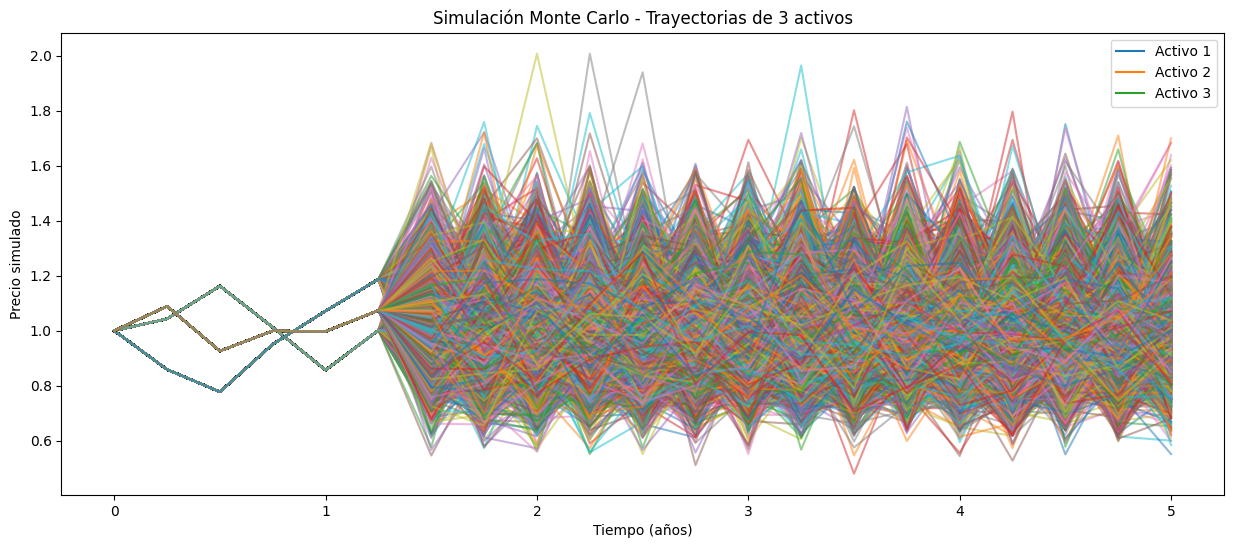

In [25]:
t = np.linspace(0, T, N+1)
fig, ax = plt.subplots(figsize=(15,6))
for i in range(3):  # tres activos
    for path in range(1000):
        ax.plot(t, P[path, :, i], alpha=0.5)
    ax.plot([], [], label=f'Activo {i+1}')  # solo para la leyenda
ax.set_title("Simulación Monte Carlo - Trayectorias de 3 activos")
ax.set_xlabel("Tiempo (años)")
ax.set_ylabel("Precio simulado")
ax.legend()
plt.show()

In [26]:
import numpy as np
def payoff_geometric_multiaset(S, S0, k, E, positive=True):
    """
    Calcula el payoff según la fórmula proporcionada (vectorizada por path).
    
    Parámetros
    ----------
    S : np.ndarray
        Precios simulados con forma (n_paths, n_steps, n_assets).
        S[:, t, i] es el precio del activo i en el paso t (t=0..n_steps-1).
    S0 : array_like
        Precios iniciales por activo (n_assets,)
    k : array_like
        Exponentes por activo (n_assets,) -> [k1, k2, k3, ...]
    E : float
        Strike / umbral que se resta de la suma de medias geométricas.
    positive : bool, default True
        Si True, devuelve max(V_T, 0). Si False, devuelve V_T (sin truncar).
    
    Retorna
    -------
    V_raw : np.ndarray
        Array de forma (n_paths,) con el valor V_T (sin truncar).
    V_payoff : np.ndarray
        Array de forma (n_paths,) con el payoff final; si positive=True, es max(V_raw,0).
    """
    S = np.asarray(S)
    S0 = np.asarray(S0)
    k = np.asarray(k)
    if S.ndim != 3:
        raise ValueError("S debe ser (n_paths, n_steps, n_assets)")
    n_paths, n_steps, n_assets = S.shape
    if S0.shape[0] != n_assets:
        raise ValueError("S0 debe tener longitud igual a n_assets (columnas de S)")
    if k.shape[0] != n_assets:
        raise ValueError("k debe tener longitud igual a n_assets")
    # Calculamos log de los productos: para cada path y activo
    # log_term[path, asset] = (1/n_steps) * sum_{j} [ k_i * ( log(S_{j,i}) - log(S0_i) ) ]
    # luego geom_mean = exp(log_term)
    log_S = np.log(S)                           # shape (n_paths, n_steps, n_assets)
    log_S0 = np.log(S0).reshape(1, 1, n_assets) # shape (1,1,n_assets) para broadcasting
    k_shaped = k.reshape(1, 1, n_assets)        # shape (1,1,n_assets)
    # suma en j
    sum_logs = np.sum(k_shaped * (log_S - log_S0), axis=1)  # shape (n_paths, n_assets)
    log_geom = sum_logs / n_steps  # (n_paths, n_assets)
    geom_terms = np.exp(log_geom)  # (n_paths, n_assets)
    # ahora sumamos sobre activos y restamos E
    V_raw = np.sum(geom_terms, axis=1) - E  # (n_paths,)
    if positive:
        V_payoff = np.maximum(V_raw, 0.0)
    else:
        V_payoff = V_raw.copy()
    return V_raw, V_payoff

In [ ]:
V_raw, V_payoff = payoff_geometric_multiaset(Ss, ultimos_precios, )

NameError: name 'ultimos_precios' is not defined